# Импортируем phout и считаем по нему разное

In [1]:
# подключаем библиотеки
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [2]:
# импортируем пхаут
phout_columns = [
    'time', 'tag', 'interval_real',
    'connect_time', 'send_time',
    'latency', 'receive_time',
    'interval_event', 'size_out',
    'size_in', 'net_code', 'proto_code']
data = pd.read_csv(
    "/home/direvius/http_phout.log",
    sep='\t', names=phout_columns)

In [3]:
# вот так выглядит наш датафрейм (точнее первые 10 строк)
data[:10]

,time,tag,interval_real,connect_time,send_time,latency,receive_time,interval_event,size_out,size_in,net_code,proto_code
0,1.448983e+09,REQUEST,38149,0,0,0,0,0,0,0,0,200
1,1.448983e+09,REQUEST,7140,0,0,0,0,0,0,0,0,200
2,1.448983e+09,REQUEST,7752,0,0,0,0,0,0,0,0,200
3,1.448983e+09,REQUEST,7673,0,0,0,0,0,0,0,0,200
4,1.448983e+09,REQUEST,7567,0,0,0,0,0,0,0,0,200
5,1.448983e+09,REQUEST,7447,0,0,0,0,0,0,0,0,200
6,1.448983e+09,REQUEST,7733,0,0,0,0,0,0,0,0,200
7,1.448983e+09,REQUEST,7893,0,0,0,0,0,0,0,0,200
8,1.448983e+09,REQUEST,7394,0,0,0,0,0,0,0,0,200
9,1.448983e+09,REQUEST,7174,0,0,0,0,0,0,0,0,200


In [4]:
# хитрые манипуляции с колонками:
# высчитываем время получения - будем группировать по нему (заводим новую колонку)
data['ts'] = data.time + data.interval_real / 1000000
# округляем до секунды
data['receive_sec'] = data.ts.astype(int)
# и индексируем по этой секунде
data.set_index(['receive_sec'], inplace=True)
# для удобства посчитаем респонс тайм в миллисекундах
data['rt_ms'] = data.interval_real / 1000
# обратите внимание на появившиеся новые колонки
data[:10]

,time,tag,interval_real,connect_time,send_time,latency,receive_time,interval_event,size_out,size_in,net_code,proto_code,ts,rt_ms
receive_sec,,,,,,,,,,,,,,
1448983240,1.448983e+09,REQUEST,38149,0,0,0,0,0,0,0,0,200,1.448983e+09,38.149
1448983240,1.448983e+09,REQUEST,7140,0,0,0,0,0,0,0,0,200,1.448983e+09,7.140
1448983240,1.448983e+09,REQUEST,7752,0,0,0,0,0,0,0,0,200,1.448983e+09,7.752
1448983240,1.448983e+09,REQUEST,7673,0,0,0,0,0,0,0,0,200,1.448983e+09,7.673
1448983240,1.448983e+09,REQUEST,7567,0,0,0,0,0,0,0,0,200,1.448983e+09,7.567
1448983240,1.448983e+09,REQUEST,7447,0,0,0,0,0,0,0,0,200,1.448983e+09,7.447
1448983240,1.448983e+09,REQUEST,7733,0,0,0,0,0,0,0,0,200,1.448983e+09,7.733
1448983240,1.448983e+09,REQUEST,7893,0,0,0,0,0,0,0,0,200,1.448983e+09,7.893
1448983240,1.448983e+09,REQUEST,7394,0,0,0,0,0,0,0,0,200,1.448983e+09,7.394


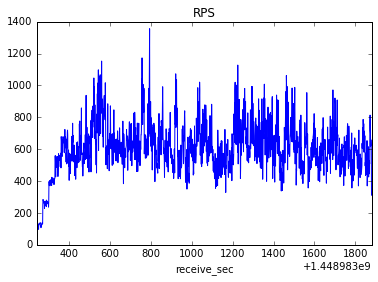

In [5]:
# группируем по индексу, считаем и рисуем график
data.groupby(level=0).count().time.plot(title="RPS")

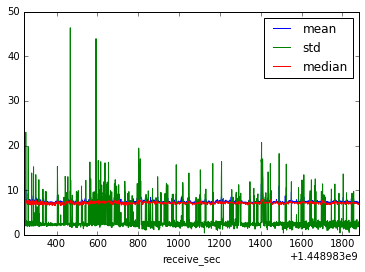

In [6]:
# группируем по индексу, считаем разные агрегаты и рисуем график
data.groupby(level=0).rt_ms.agg([np.mean, np.std, np.median]).plot()

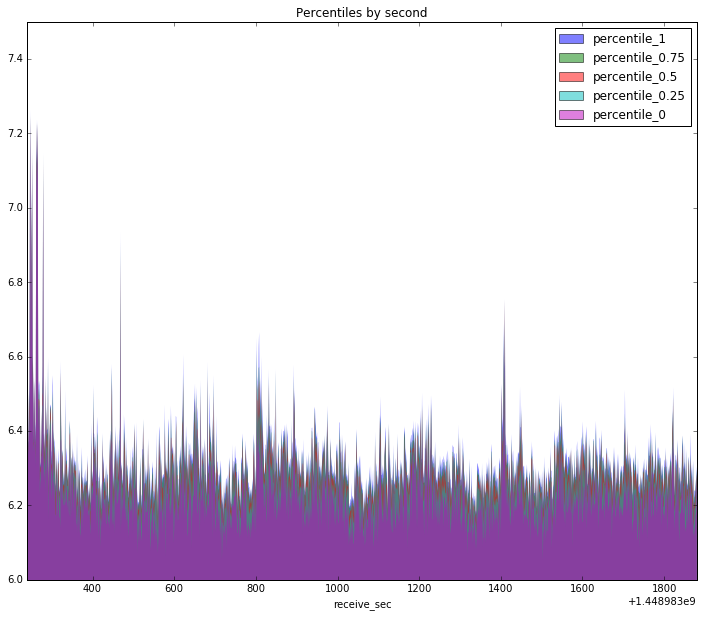

In [7]:
# percentile(n) делает функцию, которая считает персентиль n-го уровня.
# Эту функцию можно передать в аггрегатор, как выше мы передавали np.mean, np.std и np.median
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
percentiles = [percentile(n) for n in [1, .75, .5, .25, 0]]
# группируем по индексу, считаем процентили и строим
data.groupby(level=0).rt_ms.agg(percentiles).plot(
    title='Percentiles by second', kind='area', stacked=False, ylim=[6, 7.5],figsize=(12, 10), linewidth=0)

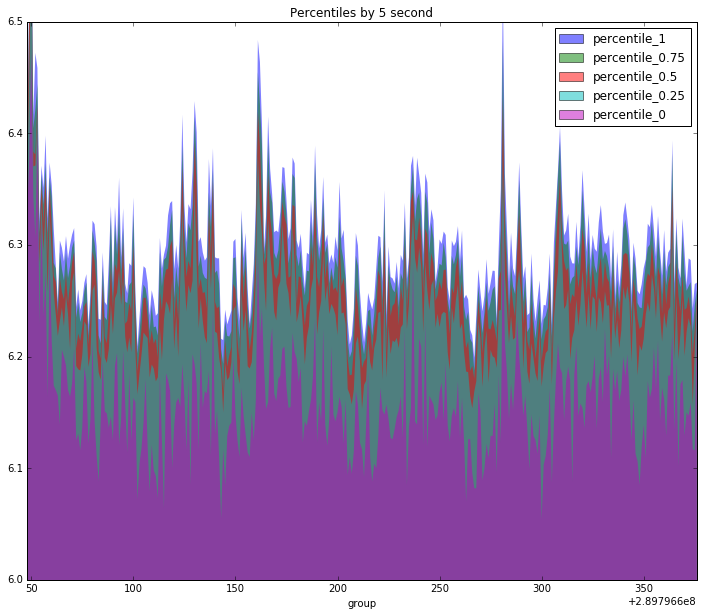

In [8]:
# сгруппируем по пять секунд, для этого сделаем новую колонку
data['group'] = data.index // 5
# и опять построим процентили
data.groupby('group').rt_ms.agg(percentiles).plot(
    title='Percentiles by 5 second', kind='area', stacked=False, ylim=[6, 6.5],figsize=(12, 10), linewidth=0)